# Start

In [31]:
# import 
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
import cv2
from skimage.color import gray2rgb
from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K 
import glob 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import random
from patchify import patchify, unpatchify
from keras.models import load_model
import pandas as pd



In [32]:

# Patch size
patch_size = 256

# Dataset directories
BASE_DIR = "/Users/celinewu/Documents/dataset_patches1"
TRAIN_IMAGE_DIR = os.path.join(BASE_DIR, "images", "train")
TRAIN_MASK_DIR = os.path.join(BASE_DIR, "masks", "train")
VAL_IMAGE_DIR = os.path.join(BASE_DIR, "images", "val")
VAL_MASK_DIR = os.path.join(BASE_DIR, "masks", "val")

# Image dimensions
IMG_HEIGHT = 256
IMG_WIDTH = 256
IMG_CHANNELS = 3 



In [33]:
train_image_paths = []
for image_path in glob.glob(f"{TRAIN_IMAGE_DIR}/*.png"):
    train_image_paths.append(image_path)

train_mask_paths = []
for mask_path in glob.glob(f"{TRAIN_MASK_DIR}/*.tif"):
    train_mask_paths.append(mask_path)

val_image_paths = []
for image_path in glob.glob(f"{VAL_IMAGE_DIR}/*.png"):
    val_image_paths.append(image_path)

val_mask_paths = []
for mask_path in glob.glob(f"{VAL_MASK_DIR}/*.tif"):
    val_mask_paths.append(mask_path)

In [34]:
# Dataset directories
BASE_DIR = "/Users/celinewu/Documents/dataset_patches1"
TRAIN_IMAGE_DIR = os.path.join(BASE_DIR, "images", "train")
TRAIN_MASK_DIR = os.path.join(BASE_DIR, "masks", "train")
VAL_IMAGE_DIR = os.path.join(BASE_DIR, "images", "val")
VAL_MASK_DIR = os.path.join(BASE_DIR, "masks", "val")


def get_valid_image_mask_pairs(image_dir, mask_dir, threshold=0.4, variance_threshold=10):
    image_files = [f for f in os.listdir(image_dir) if f.endswith('.png')]
    mask_files = [f for f in os.listdir(mask_dir) if f.endswith('.tif')]

    valid_images = []
    valid_masks = []

    for image_file in image_files:
        # Extract base name and patch number
        base_name = image_file.rsplit('_', 1)[0]  # e.g., "234778_im1"
        patch_number = image_file.split('_')[-1].replace('.png', '')  # e.g., "patch96"

        # Construct corresponding mask name
        mask_file = f"{base_name}_shoot_{patch_number}.tif"

        # Check if corresponding mask exists
        if mask_file in mask_files:
            # Check non-black content and contrast
            image_path = os.path.join(image_dir, image_file)
            mask_path = os.path.join(mask_dir, mask_file)

            image = cv2.imread(image_path, cv2.IMREAD_COLOR)
            non_black_ratio = np.sum(image > 0) / image.size
            pixel_variance = np.var(image)

            if non_black_ratio >= threshold and pixel_variance >= variance_threshold:
                valid_images.append(image_path)
                valid_masks.append(mask_path)

    return valid_images, valid_masks


# Apply filtering to training and validation datasets
train_valid_images, train_valid_masks = get_valid_image_mask_pairs(TRAIN_IMAGE_DIR, TRAIN_MASK_DIR, threshold=0.4)
val_valid_images, val_valid_masks = get_valid_image_mask_pairs(VAL_IMAGE_DIR, VAL_MASK_DIR, threshold=0.4)

# Check results
print(f"Valid Training Images: {len(train_valid_images)}")
print(f"Valid Training Masks: {len(train_valid_masks)}")
print(f"Valid Validation Images: {len(val_valid_images)}")
print(f"Valid Validation Masks: {len(val_valid_masks)}")


Valid Training Images: 27369
Valid Training Masks: 27369
Valid Validation Images: 5027
Valid Validation Masks: 5027


In [35]:
def count_mask_values(mask_paths):
    count_only_0 = 0
    count_0_and_1 = 0

    for mask_path in mask_paths:
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        unique_values = np.unique(mask)

        if np.array_equal(unique_values, [0]):
            count_only_0 += 1
        elif np.array_equal(unique_values, [0, 1]):
            count_0_and_1 += 1

    return count_only_0, count_0_and_1

# Apply the function to the filtered training masks
count_only_0, count_0_and_1 = count_mask_values(train_valid_masks)

# Print the results
print(f"Masks with unique values [0]: {count_only_0}")
print(f"Masks with unique values [0, 1]: {count_0_and_1}")


Masks with unique values [0]: 22179
Masks with unique values [0, 1]: 4995


In [36]:
def balance_masks(image_paths, mask_paths, max_zero_masks):
    zero_masks = []
    binary_masks = []

    for img_path, mask_path in zip(image_paths, mask_paths):
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        unique_values = np.unique(mask)

        if np.array_equal(unique_values, [0]):
            zero_masks.append((img_path, mask_path))
        elif np.array_equal(unique_values, [0, 1]):
            binary_masks.append((img_path, mask_path))

    # Randomly sample from zero masks to limit their count
    sampled_zero_masks = random.sample(zero_masks, min(len(zero_masks), max_zero_masks))

    # Combine sampled zero masks and all binary masks
    balanced_dataset = sampled_zero_masks + binary_masks
    balanced_images = [item[0] for item in balanced_dataset]
    balanced_masks = [item[1] for item in balanced_dataset]

    return balanced_images, balanced_masks

# Balance the training set (e.g., keep 2x the number of [0, 1] masks)
max_zero_masks = 2 * len([path for path in train_valid_masks if np.array_equal(np.unique(cv2.imread(path, cv2.IMREAD_GRAYSCALE)), [0, 1])])
balanced_train_images, balanced_train_masks = balance_masks(train_valid_images, train_valid_masks, max_zero_masks)

# Check the results
print(f"Balanced Training Images: {len(balanced_train_images)}")
print(f"Balanced Training Masks: {len(balanced_train_masks)}")


Balanced Training Images: 14985
Balanced Training Masks: 14985


In [37]:
# Balance the validation set (e.g., keep 2x the number of [0, 1] masks)
max_zero_masks_val = 2 * len([path for path in val_valid_masks if np.array_equal(np.unique(cv2.imread(path, cv2.IMREAD_GRAYSCALE)), [0, 1])])
balanced_val_images, balanced_val_masks = balance_masks(val_valid_images, val_valid_masks, max_zero_masks_val)

# Rename for consistency
val_images = balanced_val_images
val_masks = balanced_val_masks

# Verify the results
print(f"Balanced Validation Images: {len(val_images)}")
print(f"Balanced Validation Masks: {len(val_masks)}")


Balanced Validation Images: 2244
Balanced Validation Masks: 2244


In [38]:
# Count the unique values in the balanced dataset
balanced_count_only_0, balanced_count_0_and_1 = count_mask_values(balanced_train_masks)

# Print the results
print(f"Masks with unique values [0] after balancing: {balanced_count_only_0}")
print(f"Masks with unique values [0, 1] after balancing: {balanced_count_0_and_1}")


Masks with unique values [0] after balancing: 9990
Masks with unique values [0, 1] after balancing: 4995


In [39]:
# Count the unique values in the balanced dataset
balanced_count_only_0, balanced_count_0_and_1 = count_mask_values(balanced_val_masks)

# Print the results
print(f"Masks with unique values [0] after balancing: {balanced_count_only_0}")
print(f"Masks with unique values [0, 1] after balancing: {balanced_count_0_and_1}")


Masks with unique values [0] after balancing: 1496
Masks with unique values [0, 1] after balancing: 748


In [40]:
train_images = balanced_train_images
train_masks = balanced_train_masks

# Check the results
print(f"Balanced Training Images: {len(train_images)}")
print(f"Balanced Training Masks: {len(train_masks)}")
# Verify the results
print(f"Balanced Validation Images: {len(val_images)}")
print(f"Balanced Validation Masks: {len(val_masks)}")

Balanced Training Images: 14985
Balanced Training Masks: 14985
Balanced Validation Images: 2244
Balanced Validation Masks: 2244


In [41]:
# Create training dataframe
train_df = pd.DataFrame({
    'image_path': train_images,  
    'mask_path': train_masks     
})

# Create validation dataframe
val_df = pd.DataFrame({
    'image_path': val_images,  
    'mask_path': val_masks   
})

# Check the dataframes
print(train_df.head())
print(val_df.head())


                                          image_path  \
0  /Users/celinewu/Documents/dataset_patches1/ima...   
1  /Users/celinewu/Documents/dataset_patches1/ima...   
2  /Users/celinewu/Documents/dataset_patches1/ima...   
3  /Users/celinewu/Documents/dataset_patches1/ima...   
4  /Users/celinewu/Documents/dataset_patches1/ima...   

                                           mask_path  
0  /Users/celinewu/Documents/dataset_patches1/mas...  
1  /Users/celinewu/Documents/dataset_patches1/mas...  
2  /Users/celinewu/Documents/dataset_patches1/mas...  
3  /Users/celinewu/Documents/dataset_patches1/mas...  
4  /Users/celinewu/Documents/dataset_patches1/mas...  
                                          image_path  \
0  /Users/celinewu/Documents/dataset_patches1/ima...   
1  /Users/celinewu/Documents/dataset_patches1/ima...   
2  /Users/celinewu/Documents/dataset_patches1/ima...   
3  /Users/celinewu/Documents/dataset_patches1/ima...   
4  /Users/celinewu/Documents/dataset_patches1/ima... 

In [42]:
# Setup image data generators
image_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)
mask_datagen = ImageDataGenerator(horizontal_flip=True)

# Image generator for training
train_image_generator = image_datagen.flow_from_dataframe(
    train_df,
    x_col='image_path',
    y_col=None,
    target_size=(patch_size, patch_size),
    batch_size=16,
    class_mode=None,
    color_mode='rgb',
    seed=42
)

# Mask generator for training
train_mask_generator = mask_datagen.flow_from_dataframe(
    train_df,
    x_col='mask_path',
    y_col=None,
    target_size=(patch_size, patch_size),
    batch_size=16,
    class_mode=None,
    color_mode='grayscale',
    seed=42
)

# Image generator for validation
val_image_generator = image_datagen.flow_from_dataframe(
    val_df,
    x_col='image_path',
    y_col=None,
    target_size=(patch_size, patch_size),
    batch_size=16,
    class_mode=None,
    color_mode='rgb',
    seed=42
)

# Mask generator for validation
val_mask_generator = mask_datagen.flow_from_dataframe(
    val_df,
    x_col='mask_path',
    y_col=None,
    target_size=(patch_size, patch_size),
    batch_size=16,
    class_mode=None,
    color_mode='grayscale',
    seed=42
)

# Function to combine image and mask generators
def combine_generator(image_generator, mask_generator):
    while True:
        yield (next(image_generator), next(mask_generator))

# Combine training image and mask generators
train_generator = combine_generator(train_image_generator, train_mask_generator)

# Combine validation image and mask generators
val_generator = combine_generator(val_image_generator, val_mask_generator)


Found 14985 validated image filenames.
Found 14985 validated image filenames.
Found 2244 validated image filenames.
Found 2244 validated image filenames.


In [43]:
import tensorflow.keras.backend as K
import tensorflow as tf

# Dice Loss
def dice_loss(y_true, y_pred):
    smooth = 1e-6
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# Combo Loss: Binary Crossentropy + Dice
def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    return bce + dice_loss(y_true, y_pred)

# F1 metric
def f1(y_true, y_pred):
    y_pred = tf.round(y_pred)  # Round predictions to {0, 1}
    tp = tf.reduce_sum(y_true * y_pred)
    fp = tf.reduce_sum(y_pred * (1 - y_true))
    fn = tf.reduce_sum((1 - y_pred) * y_true)

    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())

    return 2 * (precision * recall) / (precision + recall + K.epsilon())



In [44]:
def basic_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    
    # Encoder
    c1 = Conv2D(32, 3, activation='relu', padding='same')(inputs)
    c1 = Conv2D(32, 3, activation='relu', padding='same')(c1)
    p1 = MaxPooling2D()(c1)
    
    c2 = Conv2D(64, 3, activation='relu', padding='same')(p1)
    c2 = Conv2D(64, 3, activation='relu', padding='same')(c2)
    p2 = MaxPooling2D()(c2)
    
    c3 = Conv2D(128, 3, activation='relu', padding='same')(p2)
    c3 = Conv2D(128, 3, activation='relu', padding='same')(c3)
    p3 = MaxPooling2D()(c3)
    
    c4 = Conv2D(256, 3, activation='relu', padding='same')(p3)
    c4 = Conv2D(256, 3, activation='relu', padding='same')(c4)
    p4 = MaxPooling2D()(c4)
    
    # Bottleneck
    c5 = Conv2D(512, 3, activation='relu', padding='same')(p4)
    c5 = Conv2D(512, 3, activation='relu', padding='same')(c5)
    
    # Decoder
    u6 = Conv2DTranspose(256, 2, strides=2, padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(256, 3, activation='relu', padding='same')(u6)
    c6 = Conv2D(256, 3, activation='relu', padding='same')(c6)
    
    u7 = Conv2DTranspose(128, 2, strides=2, padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(128, 3, activation='relu', padding='same')(u7)
    c7 = Conv2D(128, 3, activation='relu', padding='same')(c7)
    
    u8 = Conv2DTranspose(64, 2, strides=2, padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(64, 3, activation='relu', padding='same')(u8)
    c8 = Conv2D(64, 3, activation='relu', padding='same')(c8)
    
    u9 = Conv2DTranspose(32, 2, strides=2, padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(32, 3, activation='relu', padding='same')(u9)
    c9 = Conv2D(32, 3, activation='relu', padding='same')(c9)
    
    outputs = Conv2D(1, 1, activation='sigmoid')(c9)
    
    model = Model(inputs, outputs)
    return model


# Instantiate and summarize the model
basic_model = basic_unet_model(256, 256, 3)
basic_model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 256, 256,  │        896 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 256, 256,  │      9,248 │ conv2d_19[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 128, 128,  │          0 │ conv2d_20[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 128, 128,  │     18,496 │ max_pooling2d_4[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 128, 128,  │     36,928 │ conv2d_21[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 64, 64,    │          0 │ conv2d_22[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 64, 64,    │     73,856 │ max_pooling2d_5[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 64, 64,    │    147,584 │ conv2d_23[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 32, 32,    │          0 │ conv2d_24[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 32, 32,    │    295,168 │ max_pooling2d_6[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 32, 32,    │    590,080 │ conv2d_25[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 16, 16,    │          0 │ conv2d_26[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_7[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 16, 16,    │  2,359,808 │ conv2d_27[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_4  │ (None, 32, 32,    │    524,544 │ conv2d_28[0][0]   │
│ (Conv2DTranspose)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 32, 32,    │          0 │ conv2d_transpose

 Total params: 7,760,097 (29.60 MB)

 Trainable params: 7,760,097 (29.60 MB)

 Non-trainable params: 0 (0.00 B)

In [45]:
cb = EarlyStopping(
    monitor='val_loss',  
    patience=5,  
    restore_best_weights=True  
)

In [46]:
# REQUIREMENT: Compile the model before training
basic_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=bce_dice_loss,
    metrics=["accuracy", f1]
)


In [47]:
# Training generator# Train the model
history = basic_model.fit(
    train_generator,                  
    steps_per_epoch=len(train_image_paths) // 16,  
    epochs=20,                         
    validation_data=val_generator,   
    validation_steps=len(val_image_paths) // 16,  
    callbacks=[cb],     
    verbose=1                         
)
print("Model training complete.")

Epoch 1/20


2025-10-14 17:13:25.789692: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


4080/4080 ━━━━━━━━━━━━━━━━━━━━ 1617s 395ms/step - accuracy: 0.9707 - f1: 0.0691 - loss: 1.0613 - val_accuracy: 0.9946 - val_f1: 0.7111 - val_loss: 0.3547
Epoch 2/20
4080/4080 ━━━━━━━━━━━━━━━━━━━━ 2898s 710ms/step - accuracy: 0.9757 - f1: 0.4885 - loss: 0.7133 - val_accuracy: 0.9966 - val_f1: 0.8132 - val_loss: 0.2209
Epoch 3/20
4080/4080 ━━━━━━━━━━━━━━━━━━━━ 1361s 334ms/step - accuracy: 0.9771 - f1: 0.5223 - loss: 0.6679 - val_accuracy: 0.9968 - val_f1: 0.8206 - val_loss: 0.2167
Epoch 4/20
4080/4080 ━━━━━━━━━━━━━━━━━━━━ 1363s 334ms/step - accuracy: 0.9773 - f1: 0.5219 - loss: 0.6669 - val_accuracy: 0.9970 - val_f1: 0.8334 - val_loss: 0.2080
Epoch 5/20
4080/4080 ━━━━━━━━━━━━━━━━━━━━ 1371s 336ms/step - accuracy: 0.9765 - f1: 0.5199 - loss: 0.6739 - val_accuracy: 0.9971 - val_f1: 0.8334 - val_loss: 0.2034
Epoch 6/20
4080/4080 ━━━━━━━━━━━━━━━━━━━━ 1381s 339ms/step - accuracy: 0.9776 - f1: 0.5389 - loss: 0.6484 - val_accuracy: 0.9970 - val_f1: 0.8288 - val_loss: 0.2151
Epoch 7/20
4080/4080 

In [48]:
# REQUIREMENT: Save your model, it is a deliverable
# REQUIREMENT: naming convention 'studentname_studentnumber_unet_model_patchsizepx.h5'
example_file_name = f'1_celine_231265_unet_model_2_{patch_size}px.h5'
print(f"Saving model as: {example_file_name}")
basic_model.save(example_file_name)

Saving model as: 1_celine_231265_unet_model_2_256px.h5


In [49]:
# REQUIREMENT: Run and display the output of this cell.
# REQUIREMENT: Do not change the code.
best_val_loss = min(history.history['val_loss'])
best_val_f1 = max(history.history['val_f1'])
print(f"Best validation loss: {best_val_loss}")
print(f"Best validation f1: {best_val_f1}")

Best validation loss: 0.1953640729188919
Best validation f1: 0.8467164039611816


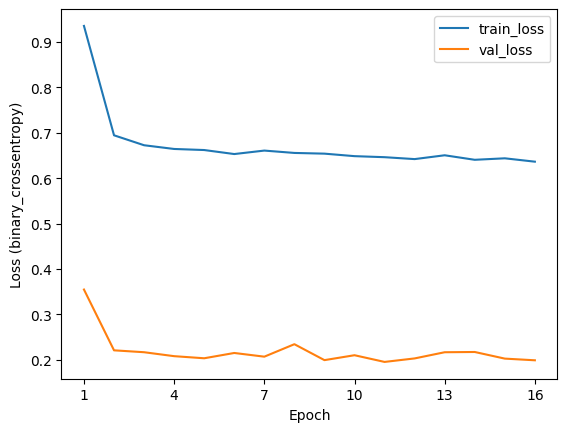

In [50]:
# REQUIREMENT: Run and display the output of this cell.
# REQUIREMENT: Do not change the code.
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = np.arange(1, len(loss) + 1)

plt.plot(epochs, loss, label='train_loss')
plt.plot(epochs, val_loss, label='val_loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss (binary_crossentropy)')
_ = plt.xticks(np.arange(1, len(loss) + 1, 3))

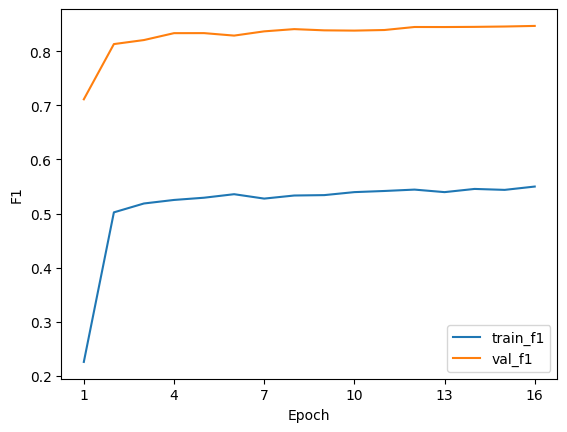

In [51]:
# REQUIREMENT: Run and display the output of this cell.
# REQUIREMENT: Do not change the code.
train_f1 = history.history['f1']
val_f1 = history.history['val_f1']

epochs = np.arange(1, len(train_f1) + 1)

plt.plot(epochs, train_f1, label='train_f1')
plt.plot(epochs, val_f1, label='val_f1')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('F1')
_ = plt.xticks(np.arange(1, len(loss) + 1, 3))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


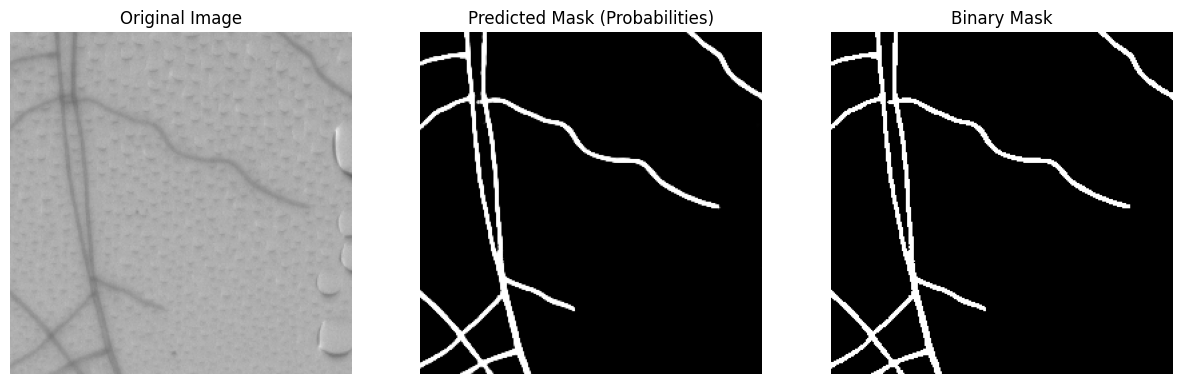

In [55]:
# Load the trained model
model = load_model("/Users/celinewu/Documents/GitHub/2024-25b-fai2-adsai-CelineWu231265/Retake/Model/1_celine_231265_unet_model_2_256px.h5", custom_objects={'f1': f1}, compile=False)


def preprocess_image(image_path, target_size):
    
    image = cv2.imread(image_path)
    image = cv2.resize(image, target_size)  # Resize to match the model input size
    image = image / 255.0  # Normalize to [0, 1]
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image

def visualize_inference(original_image_path, predicted_mask, binary_mask):
    """
    Visualizes the input image, predicted mask, and binary mask.

    Parameters:
    - original_image_path (str): Path to the original input image.
    - predicted_mask (numpy array): Predicted probabilities mask.
    - binary_mask (numpy array): Binary mask after thresholding.
    """
    original_image = cv2.imread(original_image_path)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(15, 5))

    # Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(original_image)
    plt.title("Original Image")
    plt.axis("off")

    # Predicted Mask (Probabilities)
    plt.subplot(1, 3, 2)
    plt.imshow(predicted_mask[0, :, :, 0], cmap="gray")
    plt.title("Predicted Mask (Probabilities)")
    plt.axis("off")

    # Binary Mask
    plt.subplot(1, 3, 3)
    plt.imshow(binary_mask[:, :, 0], cmap="gray")
    plt.title("Binary Mask")
    plt.axis("off")

    plt.show()

# Path to the test image
test_image_path = "/Users/celinewu/Documents/GitHub/2024-25b-fai2-adsai-CelineWu231265/datalab_tasks/task5/212231_im4_patch59 copy.png"

# Preprocess the test image
preprocessed_image = preprocess_image(test_image_path, target_size=(256, 256))

# Perform inference
predicted_mask = model.predict(preprocessed_image)

# Post-process the predicted mask (threshold at 0.5)
binary_mask = (predicted_mask > 0.5).astype(np.uint8)
binary_mask = np.squeeze(binary_mask, axis=0)  # Remove batch dimension

# Visualize the results
visualize_inference(test_image_path, predicted_mask, binary_mask)



In [56]:
def padder(image, patch_size):
    h = image.shape[0]
    w = image.shape[1]
    height_padding = ((h // patch_size) + 1) * patch_size - h
    width_padding = ((w // patch_size) + 1) * patch_size - w

    top_padding = int(height_padding/2)
    bottom_padding = height_padding - top_padding

    left_padding = int(width_padding/2)
    right_padding = width_padding - left_padding

    padded_image = cv2.copyMakeBorder(image, top_padding, bottom_padding, left_padding, right_padding, cv2.BORDER_CONSTANT, value=[0, 0, 0])

    return padded_image

In [57]:
image_path = "/Users/celinewu/Documents/GitHub/2024-25b-fai2-adsai-CelineWu231265/datalab_tasks/task5/task5_test_image.png"
image = cv2.imread(image_path)
patch_size = 256
image = padder(image, patch_size)

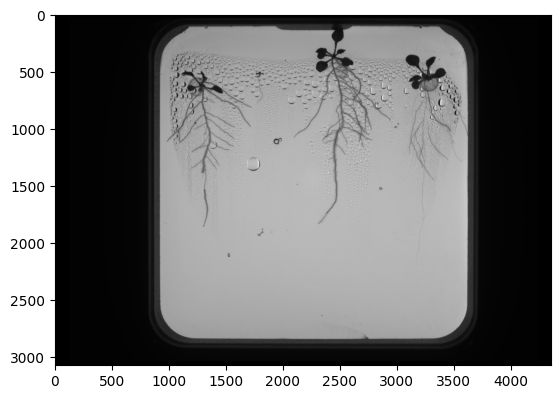

In [58]:
plt.imshow(image)

In [59]:
patches = patchify(image, (patch_size, patch_size, 3), step=patch_size)

In [60]:
i = patches.shape[0]
j = patches.shape[1]

In [61]:
patches = patches.reshape(-1, patch_size, patch_size, 3)
patches.shape

(204, 256, 256, 3)

In [62]:
preds = model.predict(patches/255)

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 185ms/step


In [63]:
preds = preds.reshape(i, j, 256, 256)
preds.shape

(12, 17, 256, 256)

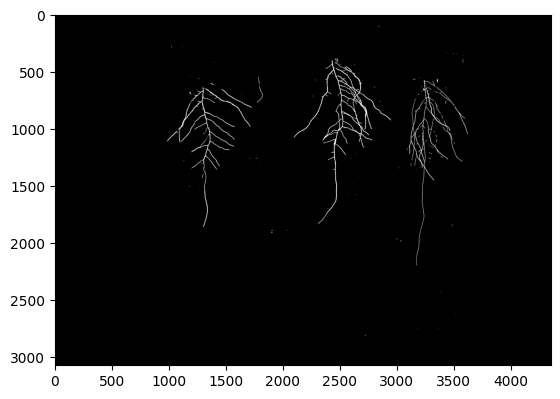

In [64]:
predicted_mask = unpatchify(preds, (image.shape[0], image.shape[1]))
plt.imshow(predicted_mask>0.5, cmap='gray')

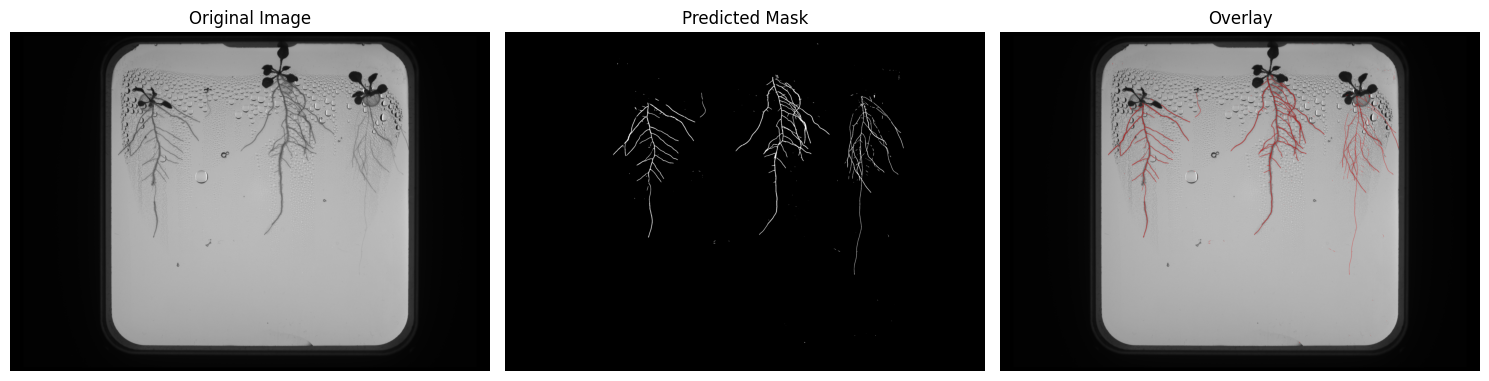

In [65]:
# Convert mask to RGB
predicted_mask_rgb = gray2rgb((predicted_mask > 0.5).astype(np.uint8) * 255)  

# Create an overlay by blending the mask with the original image
overlay = image.copy()
overlay[predicted_mask > 0.5] = [255, 0, 0]  
alpha = 0.5  # Transparency factor
blended = cv2.addWeighted(overlay, alpha, image, 1 - alpha, 0)

# Plot the results
plt.figure(figsize=(15, 5))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

# Predicted Mask
plt.subplot(1, 3, 2)
plt.imshow(predicted_mask > 0.5, cmap='gray')
plt.title("Predicted Mask")
plt.axis("off")

# Overlay
plt.subplot(1, 3, 3)
plt.imshow(blended)
plt.title("Overlay")
plt.axis("off")

plt.tight_layout()
plt.show()


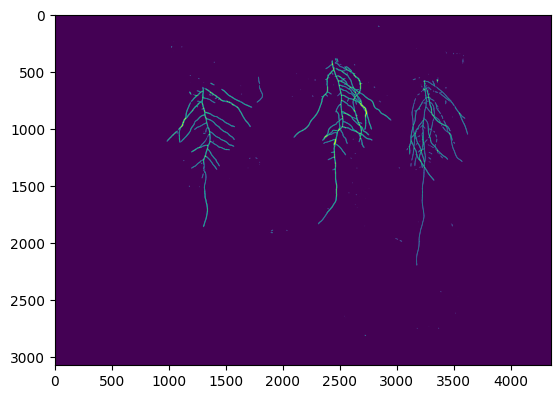

In [66]:
binary_mask = (predicted_mask > 0.5).astype(np.uint8)
plt.imshow(binary_mask)